In [1]:
import os
from os import listdir

names = []

folder_dir = "CAT_00"
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        names.append(images)

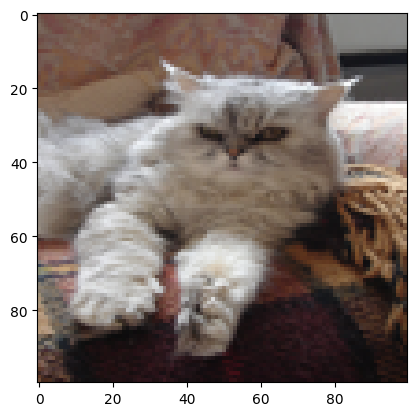

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

names = sorted(names)
img = Image.open(f"CAT_00/{names[0]}")
img = img.resize((100, 100))

imgplot = plt.imshow(img)
plt.show()

In [3]:
len(names)

9993

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianDenoiser(nn.Module):
    def __init__(self):
        super(GaussianDenoiser, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # (3, 100, 100) -> (32, 100, 100)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (32, 100, 100) -> (32, 50, 50)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # (64, 50, 50) -> (64, 25, 25)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # (64, 25, 25) -> (32, 50, 50)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),  # (32, 50, 50) -> (3, 100, 100)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = GaussianDenoiser()
print(model)

GaussianDenoiser(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [5]:
import torch

def train_step(model, x_1):
    """
    x_1: A batch of real data (images, etc.)
    model: A neural network that predicts velocity v(x, t)
    """
    # 1. Sample random noise (x_0) the same shape as our data
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample a random time step t between 0 and 1
    t = torch.rand(x_1.shape[0], 1, 1, 1) # Match dimensions
    
    # 3. Compute the point on the straight-line path (Probability Path)
    # x_t = (1 - t) * x_0 + t * x_1
    x_t = (1 - t) * x_0 + t * x_1
    
    # 4. The "Ground Truth" velocity is simply the direction of the line
    # target = x_1 - x_0
    target_velocity = x_1 - x_0
    
    # 5. Predict velocity with the model
    predicted_velocity = model(x_t)
    
    # 6. Loss is simple Mean Squared Error
    loss = torch.mean((predicted_velocity - target_velocity) ** 2)
    
    return loss

In [6]:
@torch.no_grad()
def sample(model, num_steps=20):
    # Start with pure noise
    x = torch.randn(1, 3, 64, 64)
    dt = 1.0 / num_steps
    
    for i in range(num_steps):
        t = torch.ones(1, 1, 1, 1) * (i / num_steps)
        
        # Get the velocity (direction to move)
        v = model(x)
        
        # Move a small step forward: x = x + v * dt
        x = x + v * dt
        
    return x # This is now a generated data point

In [ ]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for name in names:
    img = Image.open(f"CAT_00/{name}")
    img = img.resize((100, 100))
    img_tensor = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Normalize to [0, 1]
    
    optimizer.zero_grad()
    loss = train_step(model, img_tensor)
    loss.backward()
    optimizer.step()
    
    print(f"Processed {name}, Loss: {loss.item()}")

Processed 00000001_000.jpg, Loss: 1.0245471000671387
Processed 00000001_005.jpg, Loss: 0.9842020273208618
Processed 00000001_008.jpg, Loss: 0.9849597811698914
Processed 00000001_011.jpg, Loss: 0.9532228112220764
Processed 00000001_012.jpg, Loss: 0.9785656332969666
Processed 00000001_016.jpg, Loss: 0.9702810049057007
Processed 00000001_017.jpg, Loss: 0.9869545102119446
Processed 00000001_020.jpg, Loss: 1.0040571689605713
Processed 00000001_024.jpg, Loss: 0.9934639930725098
Processed 00000001_027.jpg, Loss: 0.9976877570152283
Processed 00000001_029.jpg, Loss: 0.9261185526847839
Processed 00000002_001.jpg, Loss: 0.9959926605224609
Processed 00000002_003.jpg, Loss: 0.9441031217575073
Processed 00000002_008.jpg, Loss: 0.9766871929168701
Processed 00000002_026.jpg, Loss: 0.926827073097229
Processed 00000003_007.jpg, Loss: 1.0014382600784302
Processed 00000003_009.jpg, Loss: 1.0045140981674194
Processed 00000003_012.jpg, Loss: 1.014852523803711
Processed 00000003_013.jpg, Loss: 0.995946764945

KeyboardInterrupt: 

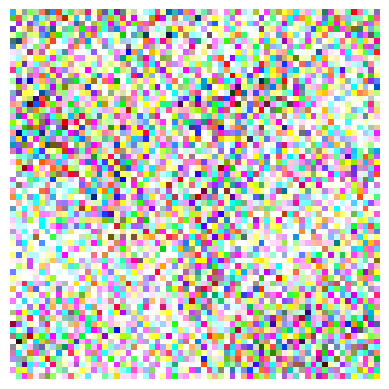

In [46]:
import matplotlib.pyplot as plt

# 1. Get the output from your sample function
output_tensor = sample(model, num_steps=50) # Shape: [1, 3, 64, 64]

# 2. Remove the batch dimension [3, 64, 64]
img_tensor = output_tensor.squeeze(0)

# 3. Rescale from [-1, 1] to [0, 1] (if necessary)
img_tensor = (img_tensor + 1) / 2

# 4. Clamp to ensure no values are outside [0, 1]
img_tensor = img_tensor.clamp(0, 1)

# 5. Permute to [64, 64, 3] and convert to CPU/NumPy
img_final = img_tensor.permute(1, 2, 0).cpu().numpy()

# 6. Plot
plt.imshow(img_final)
plt.axis('off')
plt.show()